# Pipeline Steps

### Pre-Step: Calibrate the camera to get the camera matrix and distortion coefficients
 
### Pipeline
 1. Undistort the image
 2. Threshold the image using gradients and colors
 3. Apply a Perspective Transform to view the image from top-down
 4. Identify the lane lines in warped image
 5. Un-transform back to orginal perspective and draw lane and lines

### Pre-Step: Calibrate the Camera

Before can begin developing the pipeline for decting lane lines, we need to account for the distortion in our camera. To do that, we need some information about the camera - we need to calibrate it.

By inspecting pictures of a chessboard pattern (predictable/known pattern) we can find the distoration coefficients and camera matrix that we need to undistort images.

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
ret, cMat, coefs, rvects, tvects = None, None, None, None, None

def calibrate_camera():
    im_paths = glob.glob('./camera_cal_images/calibration*.jpg')

    cb_shape = (9, 6)  # Corners we expect to be detected on the chessboard

    obj_points = []  # 3D points in real-world space
    img_points = []  # 2D points in the image

    for im_path in im_paths:
        img = mpimg.imread(im_path)

        obj_p = np.zeros((cb_shape[0]*cb_shape[1], 3), np.float32)
        coords = np.mgrid[0:cb_shape[0], 0:cb_shape[1]].T.reshape(-1, 2)  # x, y coords

        obj_p[:,:2] = coords

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        found_all, corners = cv2.findChessboardCorners(gray, cb_shape, None)
        if found_all:
            obj_points.append(obj_p)
            img_points.append(corners)
            img = cv2.drawChessboardCorners(img, cb_shape, corners, found_all)
        else:
            print("Couldn't find all corners in image:", im_path)
    
    return cv2.calibrateCamera(obj_points, img_points, gray.shape, None, None)
    
ret, cMat, coefs, rvects, tvects = calibrate_camera()
print(coefs)

[[ -2.47539663e-01  -1.51847046e-02  -1.18700379e-03  -2.48437227e-05
   -3.05600547e-02]]


#### Helper Plotting Functions

In [3]:
def side_by_side_plot(im1, im2, im1_title=None, im2_title=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(im1)
    if im1_title: ax1.set_title(im1_title, fontsize=30)
    ax2.imshow(im2)
    if im2_title: ax2.set_title(im2_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

def big_plot(img):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(img)

### Step 1: Undistort Images

Now we should be able to undistort images. Let's give it a try.

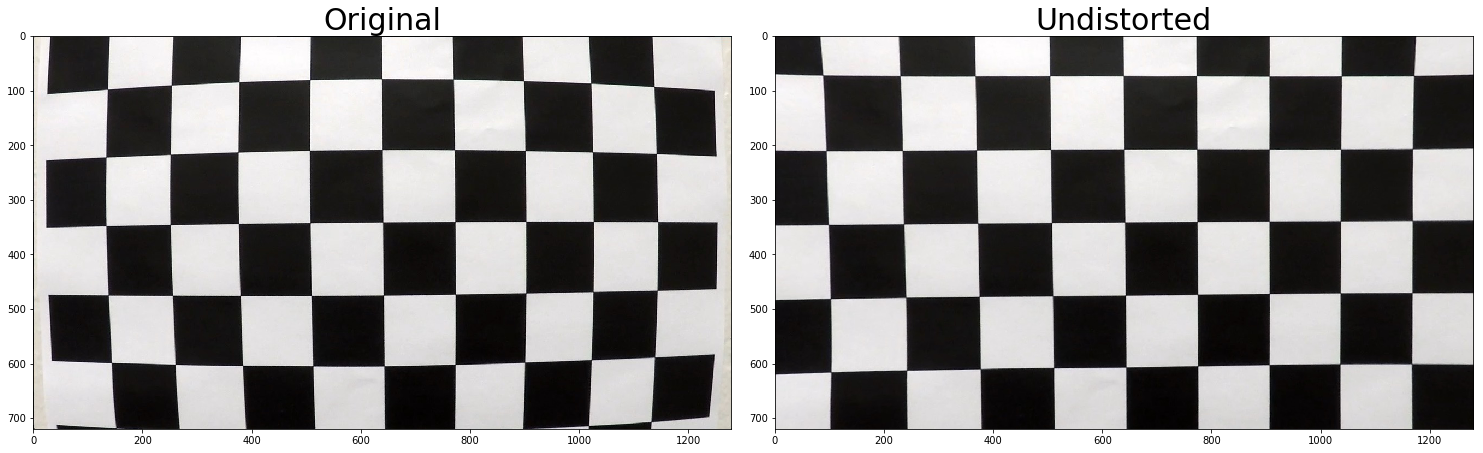

In [4]:
def undistort(img):
    if cMat is None: raise Exception('The camera needs to be calibrated first.')
    
    return cv2.undistort(img, cMat, coefs, None, cMat)
    
    
test_undistort = mpimg.imread('./camera_cal_images/not_enough_corners/calibration1.jpg')
undistorted = undistort(test_undistort)
side_by_side_plot(test_undistort, undistorted, 'Original', 'Undistorted')

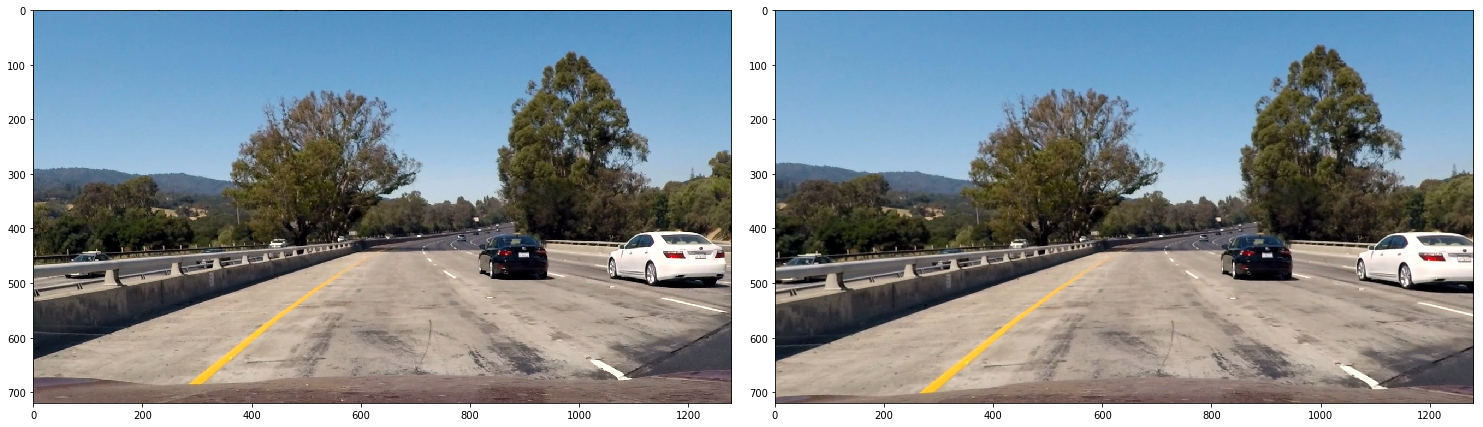

In [5]:
img = mpimg.imread('./test_images/test1.jpg')
undistorted = undistort(img)
side_by_side_plot(img, undistorted)

Both the chessboard and the road images above show the distorted (left) and undistorted (right). It's much easier to see the effect in the chessbaord image with all those parallel lines, but there are some signs in the road image like the yellow line, the hood of the car at the bottom, and the white car on the right.

### Step 2: Thresholding

With a way to undistort our distorted camera images, we now need a good thresholding method that will utilize gradients and colors to detect the lane lines in the image.

Let's create a thresholding function.

In [6]:
def get_sobel_bin(img):
    ''' "img" should be 1-channel '''
    
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=9)  # x-direction gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_bin = np.zeros_like(scaled_sobel)
    sobel_bin[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1
    
    return sobel_bin

def get_threshold(img, show=False):
    ''' "img" should be an undistorted image ''' 
    
    # Color-space conversions
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Sobel gradient binaries
    sobel_s_bin = get_sobel_bin(s_channel)
    sobel_gray_bin = get_sobel_bin(gray)
    
    sobel_comb_bin = np.zeros_like(sobel_s_bin)
    sobel_comb_bin[(sobel_s_bin == 1) | (sobel_gray_bin == 1)] = 1
    
    # HLS S-Channel binary
    s_bin = np.zeros_like(s_channel)
    s_bin[(s_channel >= 150) & (s_channel <= 255)] = 1
    
    # Combine the binaries
    comb_bin = np.zeros_like(sobel_comb_bin)
    comb_bin[(sobel_comb_bin == 1) | (s_bin == 1)] = 1
    
    gray_img = np.dstack((gray, gray, gray))
    sobel_s_img = np.dstack((sobel_s_bin, sobel_s_bin, sobel_s_bin))*255
    sobel_gray_img = np.dstack((sobel_gray_bin, sobel_gray_bin, sobel_gray_bin))*255
    sobel_comb_img = np.dstack((sobel_comb_bin, sobel_comb_bin, sobel_comb_bin))*255
    s_img = np.dstack((s_bin, s_bin, s_bin))*255
    comb_img = np.dstack((comb_bin, comb_bin, comb_bin))*255
    
    if show: side_by_side_plot(img, comb_img, 'Original', 'Thresholded')
    
    return comb_img

    
img = mpimg.imread('./test_images/test4.jpg')
threshold_img = get_threshold(img)

Great! Looks like the thresholding method works. We will combine this with the undistort method.

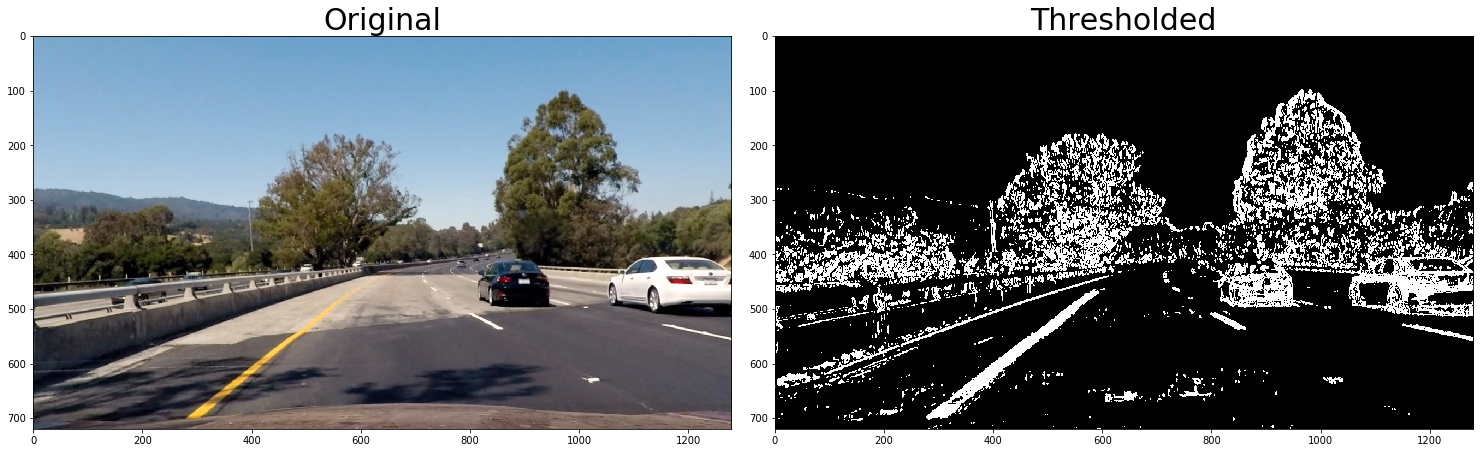

In [7]:
img = mpimg.imread('./test_images/test4.jpg')
undist = undistort(img)
threshold_img = get_threshold(undist, show=True)

### Step 3: Perspective Transform

Now that we can undistort images and threshold them to help isolate the important information, we need to further limit that information by looking only at the portion of the image we care about - the road.

To focus in on the road portion of the image we will shift our perspective to a top-down view of the road in front of the car.

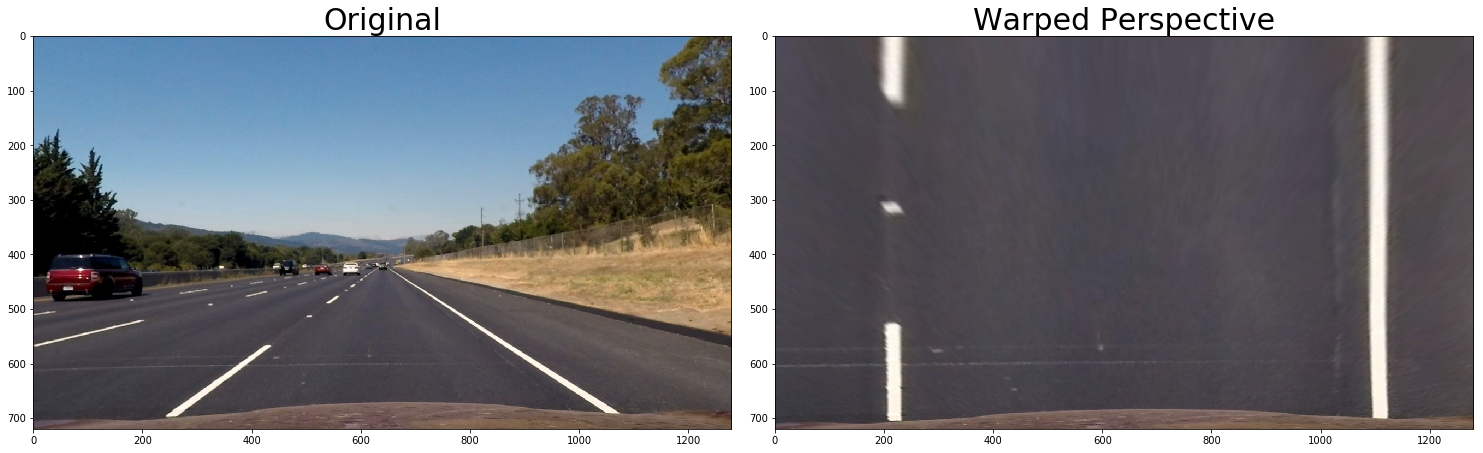

In [8]:
def warp_to_lines(img, show=False):
    ''' "img" should be an undistorted image. '''
    
    x_shape, y_shape = img.shape[1], img.shape[0]
    middle_x = x_shape//2
    top_y = 2*y_shape//3
    top_margin = 93
    bottom_margin = 450
    points = [
        (middle_x-top_margin, top_y),
        (middle_x+top_margin, top_y),
        (middle_x+bottom_margin, y_shape),
        (middle_x-bottom_margin, y_shape)
    ]

    '''
    # This shows the area we are warping to
    for i in range(len(points)):
        cv2.line(img, points[i-1], points[i], [255, 0, 0], 2)

    big_plot(img)
    '''

    src = np.float32(points)
    dst = np.float32([
        (middle_x-bottom_margin, 0),
        (middle_x+bottom_margin, 0),
        (middle_x+bottom_margin, y_shape),
        (middle_x-bottom_margin, y_shape)
    ])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (x_shape, y_shape), flags=cv2.INTER_LINEAR)
    
    if show: side_by_side_plot(img, warped, 'Original', 'Warped Perspective')
        
    return warped, M, Minv

img = mpimg.imread('./test_images/straight_lines2.jpg')
img = undistort(img)
warped, M, Minv = warp_to_lines(img, show=True)

Great! We now have a function that can warp our perspective from a forward-facing road image to a top-down roade image. The warped image will be perfect for isolating lane lines and measuring any curvature.

We will be applying this perspective warp to thresholded images.

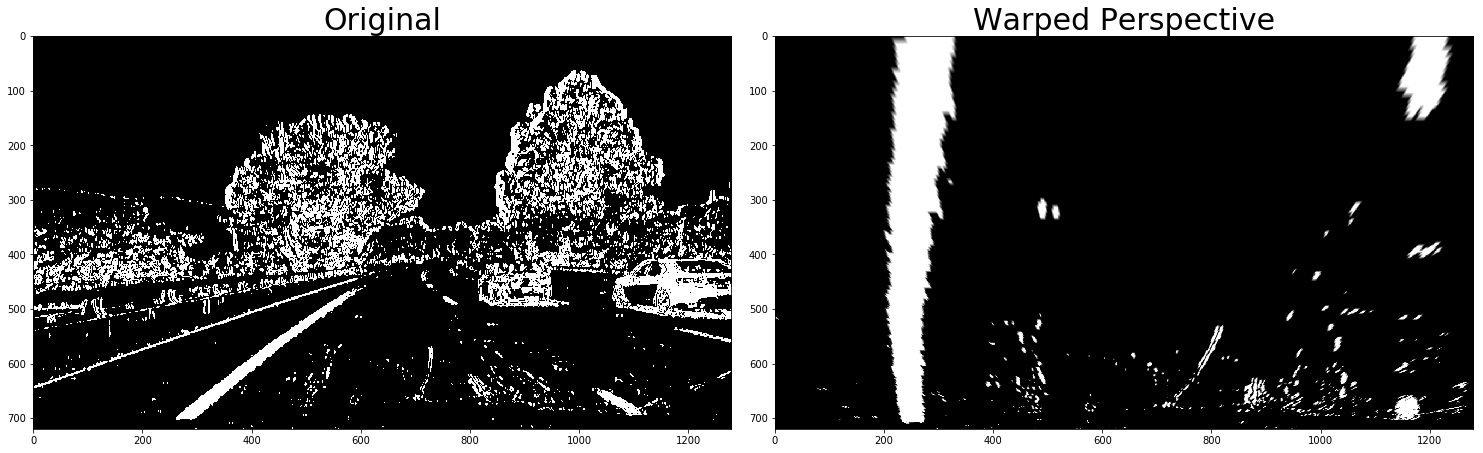

In [9]:
img = mpimg.imread('./test_images/test1.jpg')
undist = undistort(img)
thresholded = get_threshold(undist)
warped, M, Minv = warp_to_lines(thresholded, show=True)

### Step 4: Identify the Lanes

With the undistortion, thresholding, and perspective warp complete, we have all the information we need to begin isolating and identifying the lane lines.

We'll start with a histogram at the bottom of the image to identify where the lane lines start.

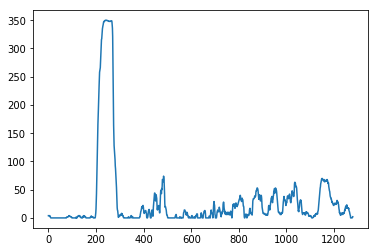

In [10]:
warped_bin = np.zeros_like(warped[:,:,0])
warped_bin[(warped[:,:,0] > 0)] = 1

histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)  # Sum the columns in the bottom half of the image
plt.plot(histogram)

The histogram's primary left and right peaks should be our lane lines. As we follow the lines using a sliding-window search, we will begin our search at these two peaks.

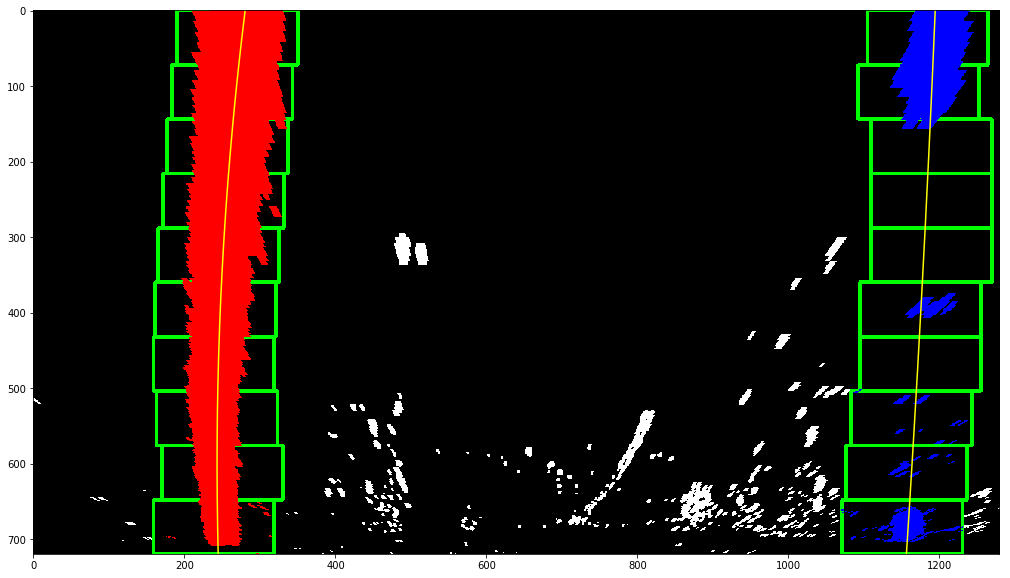

In [11]:
def find_lane(warped, show=False):
    # Create a binary version of the warped image
    warped_bin = np.zeros_like(warped[:,:,0])
    warped_bin[(warped[:,:,0] > 0)] = 1
    
    vis_img = warped.copy()  # The image we will draw on to show the lane-finding process
    vis_img[vis_img > 0] = 255  # Max out non-black pixels so we can remove them later

    # Sum the columns in the bottom portion of the image to create a histogram
    histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)
    # Find the left an right right peaks of the histogram
    midpoint = histogram.shape[0]//2
    left_x = np.argmax(histogram[:midpoint])  # x-position for the left window
    right_x = np.argmax(histogram[midpoint:]) + midpoint  # x-position for the right window

    n_windows = 10
    win_height = warped_bin.shape[0]//n_windows
    margin = 80  # Determines how wide the window is
    pix_to_recenter = margin*2  # If we find this many pixels in our window we will recenter (too few would be a bad recenter)

    # Find the non-zero x and y indices
    nonzero_ind = warped_bin.nonzero()
    nonzero_y_ind = np.array(nonzero_ind[0])
    nonzero_x_ind = np.array(nonzero_ind[1])

    left_line_ind, right_line_ind = [], []

    for win_i in range(n_windows):
        win_y_low = warped_bin.shape[0] - (win_i+1)*win_height
        win_y_high = warped_bin.shape[0] - (win_i)*win_height
        win_x_left_low = max(0, left_x - margin)
        win_x_left_high = left_x + margin
        win_x_right_low = right_x - margin
        win_x_right_high = min(warped_bin.shape[1]-1, right_x + margin)

        # Draw the windows on the vis_img
        rect_color, rect_thickness = (0, 255, 0), 3
        cv2.rectangle(vis_img, (win_x_left_low, win_y_high), (win_x_left_high, win_y_low), rect_color, rect_thickness)
        cv2.rectangle(vis_img, (win_x_right_low, win_y_high), (win_x_right_high, win_y_low), rect_color, rect_thickness)

        # Record the non-zero pixels within the windows
        left_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_left_low) &
            (nonzero_x_ind <= win_x_left_high)
        ).nonzero()[0]
        right_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_right_low) &
            (nonzero_x_ind <= win_x_right_high)
        ).nonzero()[0]
        left_line_ind.append(left_ind)
        right_line_ind.append(right_ind)

        # If there are enough pixels, re-align the window
        if len(left_ind) > pix_to_recenter:
            left_x = int(np.mean(nonzero_x_ind[left_ind]))
        if len(right_ind) > pix_to_recenter:
            right_x = int(np.mean(nonzero_x_ind[right_ind]))

    # Combine the arrays of line indices
    left_line_ind = np.concatenate(left_line_ind)
    right_line_ind = np.concatenate(right_line_ind)

    # Gather the final line pixel positions
    left_x = nonzero_x_ind[left_line_ind]
    left_y = nonzero_y_ind[left_line_ind]
    right_x = nonzero_x_ind[right_line_ind]
    right_y = nonzero_y_ind[right_line_ind]

    # Color the lines on the vis_img
    vis_img[left_y, left_x] = [254, 0, 0]  # 254 so we can isolate the white 255 later
    vis_img[right_y, right_x] = [0, 0, 254]  # 254 so we can isolate the white 255 later

    # Fit a 2nd-order polynomial to the lines
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)

    # Get our x/y vals for the fit lines
    y_vals = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0])
    left_x_vals = left_fit[0]*y_vals**2 + left_fit[1]*y_vals + left_fit[2]
    right_x_vals = right_fit[0]*y_vals**2 + right_fit[1]*y_vals + right_fit[2]

    if show:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(vis_img)
        ax.plot(left_x_vals, y_vals, color='yellow')
        ax.plot(right_x_vals, y_vals, color='yellow')
        
    lane_lines_img = vis_img.copy()
    lane_lines_img[lane_lines_img == 255] = 0  # This basically removes everything except the colored lane lines
    
    return y_vals, left_x_vals, right_x_vals, lane_lines_img

y_vals, left_x_vals, right_x_vals, lane_lines_img = find_lane(warped, show=True)

Sweet! Looks like we were able to identify the lines. A few things happened here as shown in the image above:
1. The left (red) and right (blue) lines were colored to show the pixels we identified as part of the lines.
2. The sliding windows we used for the line searches are shown at each step in green.
3. The 2nd-degree polynomial lines that fits each line are shown in yellow.

### Step 5: Warp back and draw lane and lines on original image

With the lane lines identified in the last step, it's time to wrap up the pipeline by taking that information and drawing it back onto the original image. This will in involve a reverse perspective transform, since the line/lane information was found from a warped perspective.

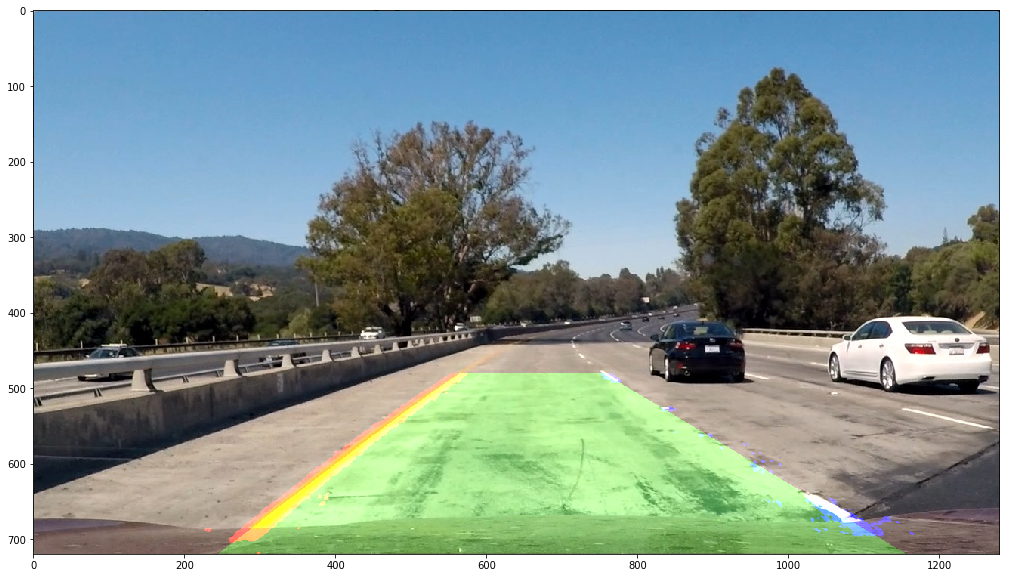

In [12]:
def draw_lane(img, lane_lines_img, y_vals, left_x_vals, right_x_vals, show=False):
    # Prepare the x/y points for cv2.fillPoly()
    left_points = np.array([np.vstack([left_x_vals, y_vals]).T])
    right_points = np.array([np.flipud(np.vstack([right_x_vals, y_vals]).T)])
    # right_points = np.array([np.vstack([right_x_vals, y_vals]).T])
    points = np.hstack((left_points, right_points))

    # Color the area between the lines (the lane)
    lane = np.zeros_like(lane_lines_img)  # Create a blank canvas to draw the lane on
    cv2.fillPoly(lane, np.int_([points]), (0, 255, 0))
    warped_lane_info = cv2.addWeighted(lane_lines_img, 1, lane, .3, 0)

    unwarped_lane_info = cv2.warpPerspective(warped_lane_info, Minv, (img.shape[1], img.shape[0]))
    drawn_img = cv2.addWeighted(img, 1, unwarped_lane_info, 1, 0)
    
    if show: big_plot(drawn_img)
        
    return drawn_img

drawn_img = draw_lane(img, lane_lines_img, y_vals, left_x_vals, right_x_vals, show=True)

# Piecing it all together
### The Complete pipeline

With all the individual parts of the lane-detection pipeline complete, all that remains is to combine them into a single pipeline function.

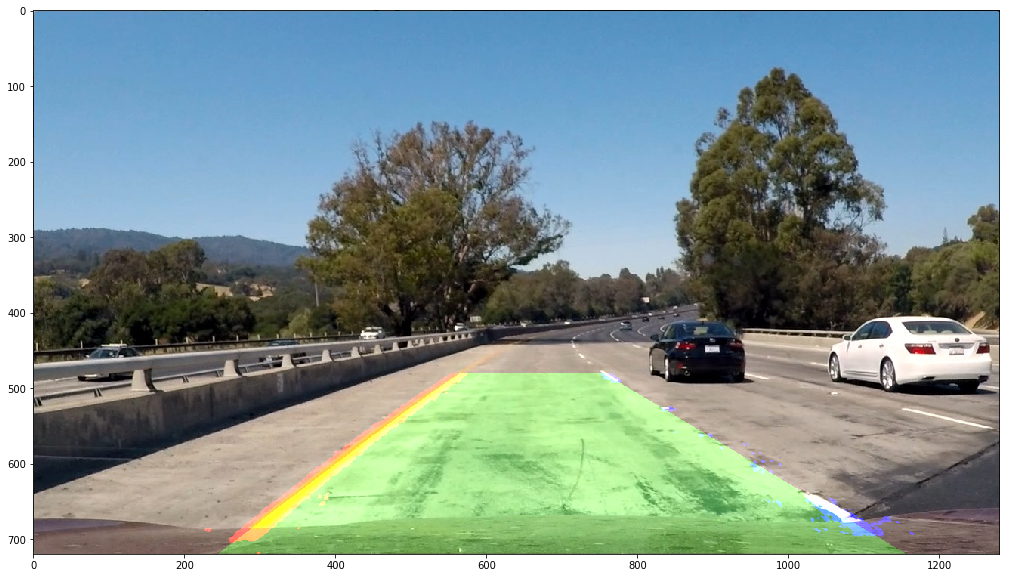

In [13]:
def detect_lane_pipe(img, show=False):
    ''' "img" can be a path or a loaded image (for the movie pipeline) '''
    
    if type(img) is str: img = mpimg.imread(img)
    undist = undistort(img)
    threshed = get_threshold(undist)
    warped, M, Minv = warp_to_lines(threshed)
    y_vals, left_x_vals, right_x_vals, lane_lines_img = find_lane(warped)
    drawn_img = draw_lane(img, lane_lines_img, y_vals, left_x_vals, right_x_vals, show=show)
    return drawn_img
    
    
drawn_img = detect_lane_pipe('./test_images/test1.jpg', show=True)

And there it is. 'detect_lane_pipe()' is our complete pipeline function for taking an image path and detecting the lane in that image.

### Creating Videos

Using this pipeline we can annotate entire videos of driving frame-by-frame using the code below.




In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
'''
video = VideoFileClip('./videos/project_video.mp4')  # Load the original video
video = video.fl_image(detect_lane_pipe)  # Pipe the video frames through the lane-detection pipeline
video = piped_video.subclip(20, 26)  # Only process a portion
%time video.write_videofile('./videos_out/project_video.mp4', audio=False)  # Write the new video
'''

"\nvideo = VideoFileClip('./videos/project_video.mp4')  # Load the original video\nvideo = video.fl_image(detect_lane_pipe)  # Pipe the video frames through the lane-detection pipeline\nvideo = piped_video.subclip(20, 26)  # Only process a portion\n%time video.write_videofile('./videos_out/project_video.mp4', audio=False)  # Write the new video\n"

Unforunately, not all frames of the video provide us with enough information to detect the lane well. To prevent erratic behavior, we need to implement some notion of tracking or smoothing. Basically, we'll assume things don't change drastically, and if they do then we resume previous behavior. Before we process any video, we need to implement this notion of tracking and smoothing.

To implement tracking and smoothing, we need a way to store information from previously processed frames. We need a Lane class.

### The Lane Class - Tracking and Smoothing

In [16]:
class Lane():
    def __init__(self, y_vals, left_x_vals, right_x_vals, lane_lines_img):
        self.y_vals = y_vals
        self.left_x_vals = left_x_vals
        self.right_x_vals = right_x_vals
        self.lane_lines_img = lane_lines_img

With the Lane class in mind, we can redefine our pipeline methods a bit. (Updates are marked with "NEW" comments.)

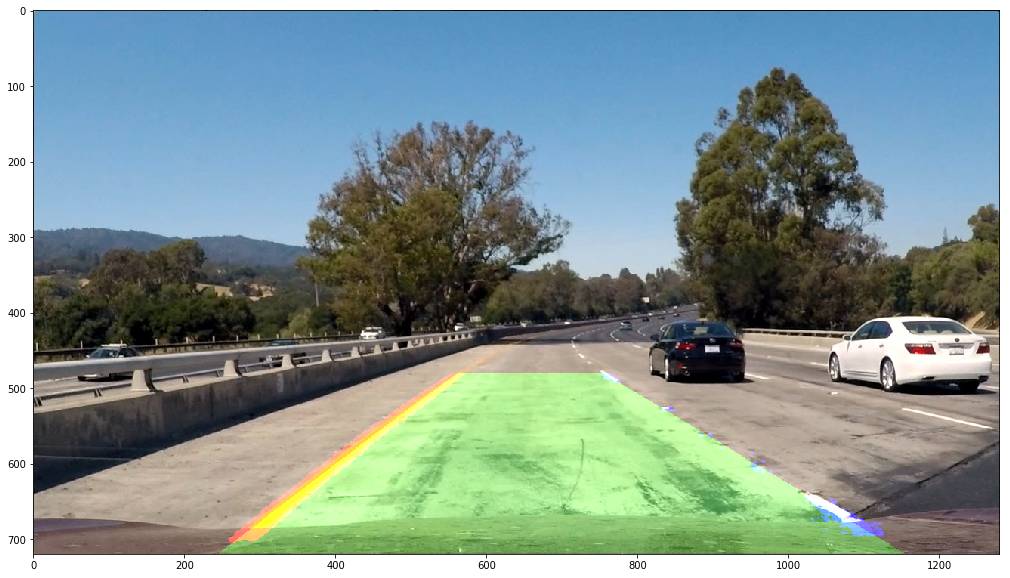

In [47]:
def find_lane(warped, show=False):
    # Create a binary version of the warped image
    warped_bin = np.zeros_like(warped[:,:,0])
    warped_bin[(warped[:,:,0] > 0)] = 1
    
    vis_img = warped.copy()  # The image we will draw on to show the lane-finding process
    vis_img[vis_img > 0] = 255  # Max out non-black pixels so we can remove them later

    # Sum the columns in the bottom portion of the image to create a histogram
    histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)
    # Find the left an right right peaks of the histogram
    midpoint = histogram.shape[0]//2
    left_x = np.argmax(histogram[:midpoint])  # x-position for the left window
    right_x = np.argmax(histogram[midpoint:]) + midpoint  # x-position for the right window

    n_windows = 10
    win_height = warped_bin.shape[0]//n_windows
    margin = 50  # Determines how wide the window is
    pix_to_recenter = margin*2  # If we find this many pixels in our window we will recenter (too few would be a bad recenter)

    # Find the non-zero x and y indices
    nonzero_ind = warped_bin.nonzero()
    nonzero_y_ind = np.array(nonzero_ind[0])
    nonzero_x_ind = np.array(nonzero_ind[1])

    left_line_ind, right_line_ind = [], []

    for win_i in range(n_windows):
        win_y_low = warped_bin.shape[0] - (win_i+1)*win_height
        win_y_high = warped_bin.shape[0] - (win_i)*win_height
        win_x_left_low = max(0, left_x - margin)
        win_x_left_high = left_x + margin
        win_x_right_low = right_x - margin
        win_x_right_high = min(warped_bin.shape[1]-1, right_x + margin)

        # Draw the windows on the vis_img
        rect_color, rect_thickness = (0, 255, 0), 3
        cv2.rectangle(vis_img, (win_x_left_low, win_y_high), (win_x_left_high, win_y_low), rect_color, rect_thickness)
        cv2.rectangle(vis_img, (win_x_right_low, win_y_high), (win_x_right_high, win_y_low), rect_color, rect_thickness)

        # Record the non-zero pixels within the windows
        left_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_left_low) &
            (nonzero_x_ind <= win_x_left_high)
        ).nonzero()[0]
        right_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_right_low) &
            (nonzero_x_ind <= win_x_right_high)
        ).nonzero()[0]
        left_line_ind.append(left_ind)
        right_line_ind.append(right_ind)

        # If there are enough pixels, re-align the window
        if len(left_ind) > pix_to_recenter:
            left_x = int(np.mean(nonzero_x_ind[left_ind]))
        if len(right_ind) > pix_to_recenter:
            right_x = int(np.mean(nonzero_x_ind[right_ind]))

    # Combine the arrays of line indices
    left_line_ind = np.concatenate(left_line_ind)
    right_line_ind = np.concatenate(right_line_ind)

    # Gather the final line pixel positions
    left_x = nonzero_x_ind[left_line_ind]
    left_y = nonzero_y_ind[left_line_ind]
    right_x = nonzero_x_ind[right_line_ind]
    right_y = nonzero_y_ind[right_line_ind]

    # Color the lines on the vis_img
    vis_img[left_y, left_x] = [254, 0, 0]  # 254 so we can isolate the white 255 later
    vis_img[right_y, right_x] = [0, 0, 254]  # 254 so we can isolate the white 255 later

    # Fit a 2nd-order polynomial to the lines
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)

    # Get our x/y vals for the fit lines
    y_vals = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0])
    left_x_vals = left_fit[0]*y_vals**2 + left_fit[1]*y_vals + left_fit[2]
    right_x_vals = right_fit[0]*y_vals**2 + right_fit[1]*y_vals + right_fit[2]

    if show:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(vis_img)
        ax.plot(left_x_vals, y_vals, color='yellow')
        ax.plot(right_x_vals, y_vals, color='yellow')
        
    lane_lines_img = vis_img.copy()
    lane_lines_img[lane_lines_img == 255] = 0  # This basically removes everything except the colored lane lines
    
    # NEW - we can now just return a Lane obj
    return Lane(y_vals, left_x_vals, right_x_vals, lane_lines_img)


# NEW - This function can now accept a Lane obj
def draw_lane(img, lane, show=False):
    # Prepare the x/y points for cv2.fillPoly()
    left_points = np.array([np.vstack([lane.left_x_vals, lane.y_vals]).T])
    right_points = np.array([np.flipud(np.vstack([lane.right_x_vals, lane.y_vals]).T)])
    # right_points = np.array([np.vstack([right_x_vals, y_vals]).T])
    points = np.hstack((left_points, right_points))

    # Color the area between the lines (the lane)
    filled_lane = np.zeros_like(lane.lane_lines_img)  # Create a blank canvas to draw the lane on
    cv2.fillPoly(filled_lane, np.int_([points]), (0, 255, 0))
    warped_lane_info = cv2.addWeighted(lane.lane_lines_img, 1, filled_lane, .3, 0)

    unwarped_lane_info = cv2.warpPerspective(warped_lane_info, Minv, (img.shape[1], img.shape[0]))
    drawn_img = cv2.addWeighted(img, 1, unwarped_lane_info, 1, 0)
    
    if show: big_plot(drawn_img)
        
    return drawn_img


def detect_lane_pipe(img, show=False):
    ''' "img" can be a path or a loaded image (for the movie pipeline) '''
    
    if type(img) is str: img = mpimg.imread(img)
    undist = undistort(img)
    threshed = get_threshold(undist)
    warped, M, Minv = warp_to_lines(threshed)
    lane = find_lane(warped)  # NEW - using the new lane class
    drawn_img = draw_lane(img, lane, show=show)  # NEW - using the new lane class
    return drawn_img
    
    
drawn_img = detect_lane_pipe('./test_images/test1.jpg', show=True)

Great! Now the pipeline identifies the lane while using the Lane class. This makes the code a little cleaner and allows us to store and use previous lane information. Now to implement tracking and smoothing.

### Tracking and Smoothing

For tracking we need to look at previous Lane detections and determine whether the current Lane detection is appropriate. If the current is too far off from the previous, something's wrong.

For smoothing we will use as a final result the average of the previous findings. This will ensure our updates don't differ sharply from the previous result and will produce a smoother video.

In [65]:
# Tests whether a new lane is appropriate compared to previously found lanes
def is_good_lane(lane):
    global prev_lanes
    global n_bad_lanes
    
    good_line_diff = True
    good_lane_area = True
    
    # Measure the total x-pixel difference between the new and the old
    if len(prev_lanes) > 0:  # If we don't have any previous lanes yet, just assume True
        prev_x_left = prev_lanes[0].left_x_vals
        prev_x_right = prev_lanes[0].right_x_vals
        current_x_left = lane.left_x_vals
        current_x_right = lane.right_x_vals

        left_diff = np.sum(np.absolute(prev_x_left - current_x_left))
        right_diff = np.sum(np.absolute(prev_x_right - current_x_right))

        lane_pixel_margin = 50  # How much different the new lane's x-values can be from the last lane
        diff_threshold = lane_pixel_margin*len(prev_x_left)

        if left_diff > diff_threshold or right_diff > diff_threshold:
            print(diff_threshold, int(left_diff), int(right_diff))
            print()
            good_line_diff = False
    
    # Make sure the area between the lane lines is appropriate (not too small or large)
    lane_area = np.sum(np.absolute(np.subtract(lane.right_x_vals, lane.left_x_vals)))
    area_min, area_max = 400000, 800000  # Area thesholds
    if lane_area < area_min or lane_area > area_max:
        print('Bad lane area:', lane_area)
        good_lane_area = False
    
    return (good_line_diff and good_lane_area)


# Averages the stored lanes for a smoothing effect
def get_avg_lane():
    global prev_lanes
    global n_bad_lanes
    
    if len(prev_lanes) == 0: return None
    elif len(prev_lanes) == 1: return prev_lanes[0]
    else:  # More than 1 previous result to average together
        n_lanes = len(prev_lanes)
        new_lane = prev_lanes[0]
        avg_lane = Lane(new_lane.y_vals, None, None, new_lane.lane_lines_img)

        left_avg = new_lane.left_x_vals
        right_avg = new_lane.right_x_vals
        for i in range(1, n_lanes):
            left_avg = np.add(left_avg, prev_lanes[i].left_x_vals)
            right_avg = np.add(right_avg, prev_lanes[i].right_x_vals)

        avg_lane.left_x_vals = left_avg / n_lanes
        avg_lane.right_x_vals = right_avg / n_lanes

        return avg_lane


def detect_lane_pipe(img, show=False):
    ''' "img" can be a path or a loaded image (for the movie pipeline) '''
    
    global prev_lanes
    global n_bad_lanes
    
    if type(img) is str: img = mpimg.imread(img)
    undist = undistort(img)
    threshed = get_threshold(undist)
    warped, M, Minv = warp_to_lines(threshed)
    lane = find_lane(warped)
    
    if is_good_lane(lane):  # If the lane is good (compared to previous lanes), add it to the list
        n_bad_lanes = 0
        prev_lanes.insert(0, lane)
        if len(prev_lanes) > 3: prev_lanes.pop()
    else:
        n_bad_lanes += 1
        
    # If we get stuck in a bad spot, don't reinforce it - just clear it out
    if n_bad_lanes >= 10:
        print('Resetting: Too many bad lanes.')
        prev_lanes = []
        n_bad_lanes = 0
            
    # If we start with some bad lanes, this will just skip the drawing
    if len(prev_lanes) == 0: return img
            
    drawn_img = draw_lane(img, get_avg_lane(), show=show)
    return drawn_img

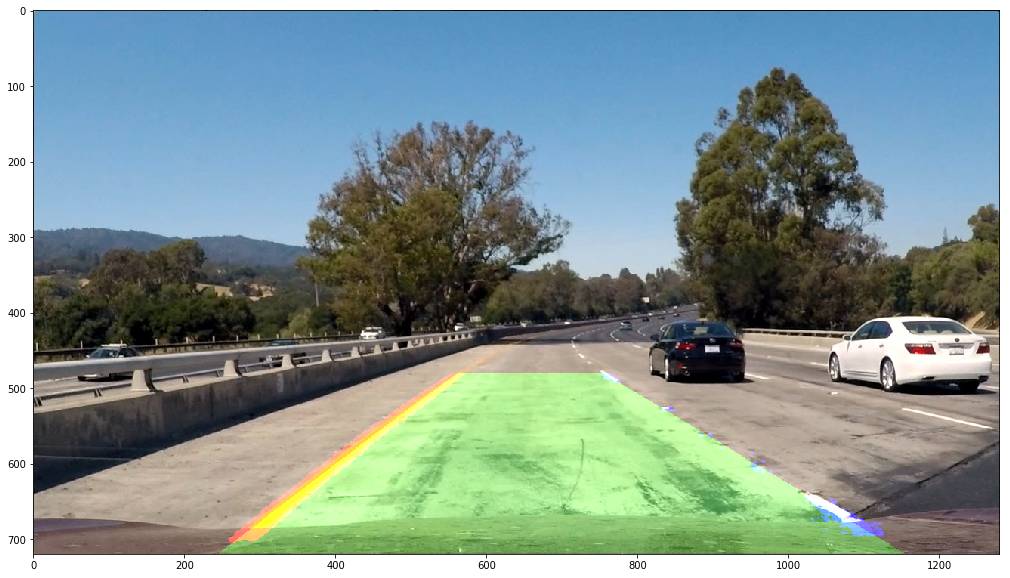

In [59]:
prev_lanes = []
n_bad_lanes = 0
drawn_img = detect_lane_pipe('./test_images/test1.jpg', show=True)

In [60]:
prev_lines = []
n_bad_lanes = 0
video = VideoFileClip('./videos/project_video.mp4')  # Load the original video
video = video.fl_image(detect_lane_pipe)  # Pipe the video frames through the lane-detection pipeline
video = video.subclip(39, 43)  # Only process a portion
%time video.write_videofile('./videos_out/project_video.mp4', audio=False)  # Write the new video

[MoviePy] >>>> Building video ./videos_out/project_video.mp4
[MoviePy] Writing video ./videos_out/project_video.mp4



 15%|█▍        | 15/101 [00:02<00:13,  6.17it/s]

36000 3840 939140

36000 8130 293810




 27%|██▋       | 27/101 [00:04<00:12,  5.91it/s]

36000 5123 175326

36000 17587 184228




 29%|██▊       | 29/101 [00:04<00:11,  6.04it/s]

36000 27515 108302

36000 38286 199787

Bad lane area: 841641.937792



 31%|███       | 31/101 [00:05<00:11,  5.94it/s]

36000 37051 32895




 42%|████▏     | 42/101 [00:07<00:10,  5.62it/s]

36000 1512 294732

Bad lane area: 407548.198161



 63%|██████▎   | 64/101 [00:11<00:06,  5.53it/s]

36000 1813 251435

Bad lane area: 424955.206293



 71%|███████▏  | 72/101 [00:12<00:05,  4.86it/s]

36000 6906 316456

Bad lane area: 354254.221759



 72%|███████▏  | 73/101 [00:12<00:05,  4.88it/s]

36000 9085 328914

Bad lane area: 357329.510916



 73%|███████▎  | 74/101 [00:13<00:05,  4.88it/s]

36000 12665 276732

Bad lane area: 413092.197032
36000 16981 71785




 76%|███████▌  | 77/101 [00:13<00:04,  5.45it/s]

36000 12037 112354




 99%|█████████▉| 100/101 [00:17<00:00,  5.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./videos_out/project_video.mp4 

CPU times: user 20.6 s, sys: 3.8 s, total: 24.4 s
Wall time: 18.6 s


In [66]:
# Challenge Video 1
prev_lines = []
n_bad_lanes = 0
video = VideoFileClip('./videos/challenge_video.mp4')  # Load the original video
video = video.fl_image(detect_lane_pipe)  # Pipe the video frames through the lane-detection pipeline
# video = video.subclip(39, 43)  # Only process a portion
%time video.write_videofile('./videos_out/challenge_video.mp4', audio=False)  # Write the new video

[MoviePy] >>>> Building video ./videos_out/challenge_video.mp4
[MoviePy] Writing video ./videos_out/challenge_video.mp4



 13%|█▎        | 64/485 [00:11<01:17,  5.45it/s]

36000 1436 210001

36000 2068 211225




 14%|█▍        | 67/485 [00:12<01:15,  5.52it/s]

36000 4720 211421

36000 2785 212664




 14%|█▍        | 69/485 [00:12<01:15,  5.48it/s]

36000 3106 211139

36000 2959 207051




 15%|█▍        | 71/485 [00:12<01:14,  5.54it/s]

36000 9777 205577

36000 13709 204379




 15%|█▌        | 73/485 [00:13<01:13,  5.60it/s]

36000 6581 201072

36000 9904 198891

Resetting: Too many bad lanes.



 16%|█▋        | 79/485 [00:14<01:05,  6.16it/s]

36000 3295 246517

Bad lane area: 270278.28267



 19%|█▉        | 91/485 [00:16<01:05,  6.03it/s]

36000 2776 242826

Bad lane area: 280111.75227
36000 5795 242289

Bad lane area: 278370.707976



 19%|█▉        | 93/485 [00:16<01:05,  5.98it/s]

36000 3857 241349

Bad lane area: 280503.064535



 22%|██▏       | 105/485 [00:18<01:03,  5.99it/s]

36000 5239 244511

Bad lane area: 254835.60406
36000 3146 245567

Bad lane area: 251550.614947



 22%|██▏       | 107/485 [00:18<01:04,  5.89it/s]

36000 6031 246410

Bad lane area: 253829.887784
36000 7112 247169

Bad lane area: 254121.71629



 25%|██▍       | 119/485 [00:20<01:02,  5.89it/s]

36000 2545 252709

Bad lane area: 261083.277101
36000 3168 252594

Bad lane area: 263275.163127



 25%|██▍       | 121/485 [00:21<01:02,  5.80it/s]

36000 2673 252792

Bad lane area: 262212.89733
36000 5352 253345

Bad lane area: 265410.024227



 26%|██▌       | 127/485 [00:22<00:58,  6.14it/s]

36000 11511 76504




 27%|██▋       | 129/485 [00:22<00:58,  6.12it/s]

36000 8850 46628




 27%|██▋       | 133/485 [00:23<00:57,  6.13it/s]

36000 13311 261265

Bad lane area: 248759.079321
36000 6338 261510

Bad lane area: 266875.943484



 28%|██▊       | 135/485 [00:23<00:56,  6.19it/s]

36000 7998 261829

Bad lane area: 268217.213329
36000 40721 262348

Bad lane area: 300420.607507



 28%|██▊       | 137/485 [00:23<00:56,  6.17it/s]

36000 78487 259270

Bad lane area: 341265.579416
36000 76761 261550

Bad lane area: 337259.943511



 29%|██▊       | 139/485 [00:24<00:56,  6.15it/s]

36000 203386 259820

36000 231804 259538




 29%|██▉       | 141/485 [00:24<00:55,  6.23it/s]

36000 236621 259227

36000 223374 259134

Resetting: Too many bad lanes.



 29%|██▉       | 143/485 [00:24<00:53,  6.41it/s]

Bad lane area: 246709.246833
Bad lane area: 241400.615547



 30%|██▉       | 145/485 [00:25<00:52,  6.51it/s]

Bad lane area: 266065.670345
Bad lane area: 274361.275679



 30%|███       | 147/485 [00:25<00:51,  6.57it/s]

Bad lane area: 282952.332318
Bad lane area: 253074.885125



 31%|███       | 149/485 [00:25<00:52,  6.42it/s]

Bad lane area: 248863.265003
Bad lane area: 250307.318734



 32%|███▏      | 153/485 [00:26<00:54,  6.10it/s]

36000 1036 237606

Bad lane area: 245214.924216



 32%|███▏      | 155/485 [00:26<00:55,  5.94it/s]

36000 1750 236288

Bad lane area: 248222.10076
36000 3661 236852

Bad lane area: 249271.402073



 32%|███▏      | 157/485 [00:27<00:56,  5.82it/s]

36000 5713 237116

Bad lane area: 251356.778629
36000 8125 237213

Bad lane area: 253284.746065



 33%|███▎      | 159/485 [00:27<00:55,  5.84it/s]

36000 8903 237415

Bad lane area: 252957.4858
36000 10780 237790

Bad lane area: 254507.220075



 33%|███▎      | 161/485 [00:27<00:55,  5.85it/s]

36000 9508 237883

Bad lane area: 253424.539515
36000 12208 238280

Bad lane area: 256590.80539



 34%|███▎      | 163/485 [00:28<00:53,  6.07it/s]

36000 14070 238479

Bad lane area: 258331.8005
36000 14084 238597

Bad lane area: 258246.808806
Resetting: Too many bad lanes.



 36%|███▌      | 173/485 [00:29<00:56,  5.56it/s]

36000 3514 232392

Bad lane area: 260335.874337
36000 3153 232477

Bad lane area: 259513.309354



 36%|███▌      | 175/485 [00:30<00:54,  5.67it/s]

36000 5939 233135

Bad lane area: 258144.258956
36000 9999 233657

Bad lane area: 257723.236485



 39%|███▊      | 187/485 [00:32<00:49,  5.99it/s]

36000 5619 244846

Bad lane area: 254737.325515
36000 7745 245108

Bad lane area: 255256.321095



 39%|███▉      | 189/485 [00:32<00:50,  5.86it/s]

36000 8336 244928

Bad lane area: 256343.569997
36000 8944 244429

Bad lane area: 256396.117303



 39%|███▉      | 191/485 [00:32<00:50,  5.83it/s]

36000 9230 244477

Bad lane area: 255989.999462
36000 9512 245112

Bad lane area: 256996.790526



 40%|████      | 195/485 [00:33<00:52,  5.57it/s]

36000 1633 240777

Bad lane area: 253873.780461
36000 3706 239917

Bad lane area: 252660.088611



 41%|████      | 197/485 [00:34<00:51,  5.64it/s]

36000 6566 239579

Bad lane area: 250138.632991
36000 7058 238894

Bad lane area: 250331.298682



 41%|████      | 200/485 [00:34<00:48,  5.83it/s]

36000 2258 234019

Bad lane area: 252261.3542
36000 1768 233577

Bad lane area: 252214.288213



 42%|████▏     | 202/485 [00:34<00:49,  5.70it/s]

36000 2325 232785

Bad lane area: 253563.407159
36000 2901 233731

Bad lane area: 253193.483138



 44%|████▍     | 214/485 [00:36<00:46,  5.85it/s]

36000 2378 224471

Bad lane area: 259466.446069
36000 1791 224573

Bad lane area: 259419.289272



 45%|████▍     | 216/485 [00:37<00:46,  5.77it/s]

36000 5228 224348

Bad lane area: 262519.141525
36000 8568 224231

Bad lane area: 266680.126802



 45%|████▍     | 218/485 [00:37<00:47,  5.65it/s]

36000 6079 223508

Bad lane area: 264971.495552



 47%|████▋     | 229/485 [00:39<00:43,  5.88it/s]

36000 675 223446

Bad lane area: 261872.242248
36000 1591 223537

Bad lane area: 263645.838053



 48%|████▊     | 231/485 [00:39<00:44,  5.75it/s]

36000 2399 223935

Bad lane area: 261872.193507



 50%|█████     | 243/485 [00:41<00:41,  5.85it/s]

36000 1663 220896

Bad lane area: 259773.304316
36000 2808 220605

Bad lane area: 261295.481151



 51%|█████     | 245/485 [00:42<00:41,  5.81it/s]

36000 4499 220551

Bad lane area: 263039.860021



 53%|█████▎    | 256/485 [00:44<00:38,  5.93it/s]

36000 1080 234218

Bad lane area: 262372.115945
36000 1914 234410

Bad lane area: 263407.844336



 53%|█████▎    | 258/485 [00:44<00:38,  5.93it/s]

36000 2066 234109

Bad lane area: 263860.722422
36000 1947 234106

Bad lane area: 263296.695199



 56%|█████▌    | 270/485 [00:46<00:36,  5.88it/s]

36000 2142 234074

Bad lane area: 268026.910796
36000 3252 234359

Bad lane area: 269951.801006



 56%|█████▌    | 272/485 [00:46<00:36,  5.80it/s]

36000 6044 234129

Bad lane area: 267264.281763
36000 5972 234238

Bad lane area: 267023.434173



 59%|█████▉    | 285/485 [00:49<00:33,  5.92it/s]

36000 2350 221930

Bad lane area: 260997.303693
36000 5292 222848

Bad lane area: 263025.362131



 61%|██████▏   | 298/485 [00:51<00:32,  5.69it/s]

36000 1405 229994

Bad lane area: 258476.281377
36000 4065 230428

Bad lane area: 260759.427784



 62%|██████▏   | 299/485 [00:51<00:32,  5.65it/s]

36000 6635 231198

Bad lane area: 262559.642008
36000 8642 231422

Bad lane area: 264343.757945



 64%|██████▍   | 312/485 [00:53<00:29,  5.82it/s]

36000 2164 226800

Bad lane area: 260053.993967
36000 4360 226436

Bad lane area: 262629.246121



 65%|██████▍   | 314/485 [00:54<00:29,  5.81it/s]

36000 4268 226623

Bad lane area: 263924.620459
36000 5476 226712

Bad lane area: 265045.001057



 67%|██████▋   | 325/485 [00:56<00:27,  5.87it/s]

36000 843 228732

Bad lane area: 265354.370969
36000 2389 230106

Bad lane area: 262373.495889



 67%|██████▋   | 327/485 [00:56<00:27,  5.81it/s]

36000 2383 228746

Bad lane area: 263787.189042
36000 2508 229535

Bad lane area: 263923.136416



 68%|██████▊   | 332/485 [00:57<00:26,  5.83it/s]

36000 3850 225976

Bad lane area: 256511.29283
36000 2423 226447

Bad lane area: 257468.003506



 69%|██████▉   | 334/485 [00:57<00:26,  5.68it/s]

36000 1907 227792

Bad lane area: 256951.41486
36000 3605 228128

Bad lane area: 260611.39773



 69%|██████▉   | 336/485 [00:58<00:25,  5.82it/s]

36000 4214 228797

Bad lane area: 260619.200224



 70%|██████▉   | 338/485 [00:58<00:25,  5.85it/s]

36000 1323 225054

Bad lane area: 261983.814082
36000 4618 226730

Bad lane area: 257513.135344



 70%|███████   | 340/485 [00:58<00:24,  5.86it/s]

36000 4634 225238

Bad lane area: 261992.078742
36000 3702 223060

Bad lane area: 266397.143805



 71%|███████   | 342/485 [00:59<00:24,  5.89it/s]

36000 6691 224769

Bad lane area: 266525.516719
36000 7486 226263

Bad lane area: 263789.21388



 72%|███████▏  | 348/485 [01:00<00:23,  5.86it/s]

36000 2242 229364

Bad lane area: 257694.507532
36000 3178 230516

Bad lane area: 253547.347035



 72%|███████▏  | 349/485 [01:00<00:23,  5.89it/s]

36000 605 231433

Bad lane area: 253818.354348



 73%|███████▎  | 352/485 [01:00<00:23,  5.56it/s]

36000 730 221309

Bad lane area: 250247.674995
36000 1699 221510

Bad lane area: 250536.633993



 73%|███████▎  | 354/485 [01:01<00:23,  5.61it/s]

36000 3780 221508

Bad lane area: 252899.953198
36000 2742 221718

Bad lane area: 252249.512572



 73%|███████▎  | 356/485 [01:01<00:23,  5.52it/s]

36000 3463 221799

Bad lane area: 252889.768231
36000 2172 221930

Bad lane area: 250993.195864



 74%|███████▍  | 358/485 [01:01<00:22,  5.71it/s]

36000 2681 222587

Bad lane area: 251319.416355
36000 3169 223212

Bad lane area: 251183.255466



 74%|███████▍  | 360/485 [01:02<00:21,  5.91it/s]

36000 2976 223417

Bad lane area: 250784.193383
36000 2927 225038

Bad lane area: 248643.954311
Resetting: Too many bad lanes.



 75%|███████▍  | 362/485 [01:02<00:20,  6.04it/s]

Bad lane area: 244632.172025
Bad lane area: 243100.013532



 75%|███████▌  | 364/485 [01:02<00:20,  6.00it/s]

Bad lane area: 245212.051242
Bad lane area: 242316.6574



 75%|███████▌  | 366/485 [01:03<00:19,  5.96it/s]

Bad lane area: 242295.351142
Bad lane area: 238323.94597



 76%|███████▌  | 368/485 [01:03<00:19,  5.86it/s]

Bad lane area: 235559.541513
Bad lane area: 234924.102495



 76%|███████▋  | 370/485 [01:03<00:19,  5.96it/s]

Bad lane area: 234088.508299
Bad lane area: 233279.451989
Resetting: Too many bad lanes.



 77%|███████▋  | 372/485 [01:04<00:18,  6.11it/s]

Bad lane area: 235587.005772
Bad lane area: 235419.561666



 77%|███████▋  | 374/485 [01:04<00:17,  6.20it/s]

Bad lane area: 231842.290353
Bad lane area: 232919.618963



 78%|███████▊  | 376/485 [01:04<00:17,  6.24it/s]

Bad lane area: 219604.046222
Bad lane area: 223881.499164



 78%|███████▊  | 378/485 [01:05<00:17,  6.24it/s]

Bad lane area: 228720.362683
Bad lane area: 231867.90156



 78%|███████▊  | 380/485 [01:05<00:16,  6.38it/s]

Bad lane area: 223755.31894
Bad lane area: 212961.372663
Resetting: Too many bad lanes.



 79%|███████▉  | 382/485 [01:05<00:16,  6.30it/s]

Bad lane area: 216236.999263
Bad lane area: 221049.181854



 79%|███████▉  | 384/485 [01:06<00:16,  6.26it/s]

Bad lane area: 219342.550194
Bad lane area: 222915.197494



 80%|███████▉  | 386/485 [01:06<00:16,  6.12it/s]

Bad lane area: 0.0



 83%|████████▎ | 401/485 [01:09<00:13,  6.03it/s]

36000 196126 1801

Bad lane area: 282055.873623
36000 194442 6152

Bad lane area: 288169.433465



 87%|████████▋ | 422/485 [01:12<00:10,  6.01it/s]

36000 128913 1668

Bad lane area: 342275.39078
36000 125176 8455

Bad lane area: 352798.94835



 88%|████████▊ | 426/485 [01:13<00:10,  5.87it/s]

36000 119249 1483

Bad lane area: 366936.562507
36000 117890 5785

Bad lane area: 363993.568976



 88%|████████▊ | 429/485 [01:13<00:09,  5.72it/s]

36000 116143 7951

Bad lane area: 366554.671385
36000 113104 7919

Bad lane area: 366646.190056



 89%|████████▉ | 431/485 [01:14<00:09,  5.78it/s]

36000 107932 2181

Bad lane area: 381064.869355
36000 104682 4456

Bad lane area: 387442.902842



 89%|████████▉ | 433/485 [01:14<00:08,  5.78it/s]

36000 98308 5998

Bad lane area: 395260.361846
36000 93202 9252




 89%|████████▉ | 434/485 [01:14<00:08,  5.79it/s]

36000 89653 10304




 93%|█████████▎| 452/485 [01:17<00:05,  6.29it/s]

36000 1180 713332

Bad lane area: 1212834.67122



 96%|█████████▌| 465/485 [01:19<00:03,  6.35it/s]

36000 2837 376450

36000 4167 203787




 96%|█████████▋| 467/485 [01:19<00:02,  6.27it/s]

36000 5438 97385




 99%|█████████▊| 478/485 [01:21<00:01,  6.44it/s]

36000 1545 1018898

Bad lane area: 1538973.70343
36000 4562 1135280

Bad lane area: 1652338.06164



 99%|█████████▉| 480/485 [01:22<00:00,  6.46it/s]

36000 3200 887948

Bad lane area: 1406756.14433
36000 5052 1014204

Bad lane area: 1530772.69531



100%|██████████| 485/485 [01:22<00:00,  6.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./videos_out/challenge_video.mp4 

CPU times: user 1min 35s, sys: 18.7 s, total: 1min 54s
Wall time: 1min 23s
